<a href="https://colab.research.google.com/github/VanishingPizza/GenAI/blob/main/HW2/Assignment_2_Image_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation with a Diffuser Model**

* We need to install the following libraries:

   1. **diffusers**: This is the core library that contains the Stable **Diffusion Pipeline**.

   2. **transformers**: This provides the **CLIP model**, which acts as the translator between the text prompt and the image generator.

   3. **accelerate**: This helps handle the heavy mathematical lifting on the GPU.
   
   4. Make sure to ask for a GPU to run this norebook:

   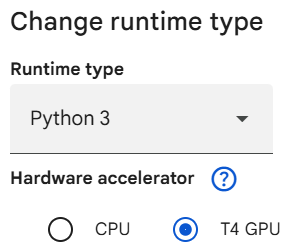



In [ ]:
# the needed libraries
!pip install diffusers transformers accelerate



In [ ]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

# **The Running Environment**

1. We first go to the **Hugging Face Model Hub** and download all the AI models such as the VAE, the **CLIP** tokenizer, etc.

2. **CLIP** stands for **Contrastive Language-Image Pre-training**
   * A model developed by OpenAI that acts as a bridge between **words** and **pictures**.
   
   * **CLIP** was trained by looking at 400 million pairs of images and their captions from the internet to learn how they relate.

   * E.g. If you show it a **photo of a dog** and **the text "a photo of a dog,"** it learns to push those together in its **latent space**.

2. We then move the 4GB+ of model weights from the computer's general memory into the Graphics Card's memory.

3. A CPU might take 5 minutes to make one image but aa CUDA-enabled GPU (NVIDIA) can do it in 2 seconds.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")





# **The Sculptor**

* **Stable Diffusion** creates images by starting with some noise and slowly cleaning it up.

* The **seed** is the number that determines exactly what that static looks like before the AI starts its work. So, if you use Seed 42, the formula always spits out the exact same pattern of noise.


* **num_inference_steps** is the most important parameter here

* It tells the AI how many times to **chip away** at the noise.

    * **1-10 Steps**: You'll see blurry blobs

    * **20-50 Steps**: You'll see sharper details and textures

* **Note**:

  * **CLIP**, the **translator**, uses **Visual Tokens** (14x14 patches).
  * It needs them to **read** an image so it can match it to a caption.
  * **Stable Diffusion**, the **sculptor**, uses a **Latent Space**.


In [ ]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(60)

pipe.set_progress_bar_config(disable=True)

image = pipe(
    prompt = "a mechanical dragon shooting green lines of code as fire,8k,raytracing",
    generator=generator,
    num_inference_steps=50,
    guidance_scale=7.5
).images[0]

image

# **Image Diffusion in Steps**

---
1. **Training or the "Learning" process**

 * We teach the AI to be a **restorer**
 * We take a perfectly clear image
 * We intentionally destroy it by **adding layers of random Gaussian noise (epsilon)** until it is unrecognizable:

 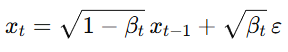

* Where,
  * X_t-1 is the image at the previous step
  * X_t is the image afteradding noise
  * beta_t is how much noise we want to add

 * We show the AI **each noisy image** and **the actual noise** we added.
 * We then ask: **"Can you predict exactly what noise I just added?"**

  * The AI gets better and better at identifying the  **signature** of noise versus the **signature** of a cat

---
**2. Generation or the "Creative" process**

* We start with a **block of pure noise** with a  random seed
* **CLIP** takes the prompt and tells the image **sculptor** what to look for in that noise.

 * The **sculptor** looks at the noise and decides **some of this noise looks like a cat's ear**. It then predicts that noise and subtracts it.

 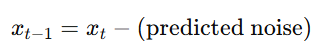

 * This happens 30–50 times, while each step makes the image slightly cleaner until the final image is produced.

 ---


 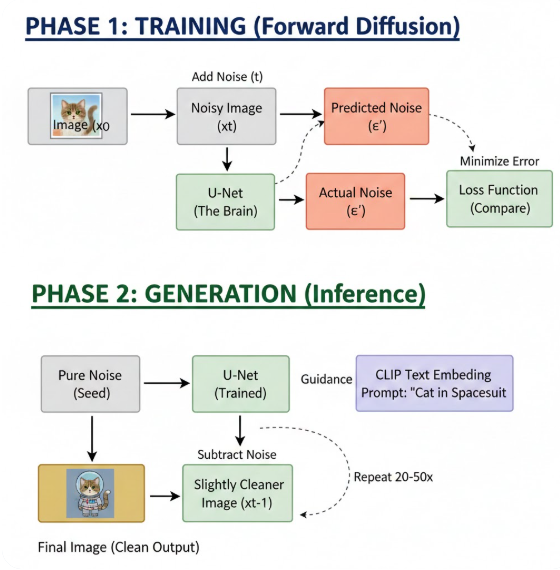



In [ ]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []
pipe.set_progress_bar_config(disable=True)

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="a mechanical dragon shooting green lines of code as fire,8k,raytracing",
    generator=generator,
    num_inference_steps=50,
    guidance_scale=30.0,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
# intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Analysis

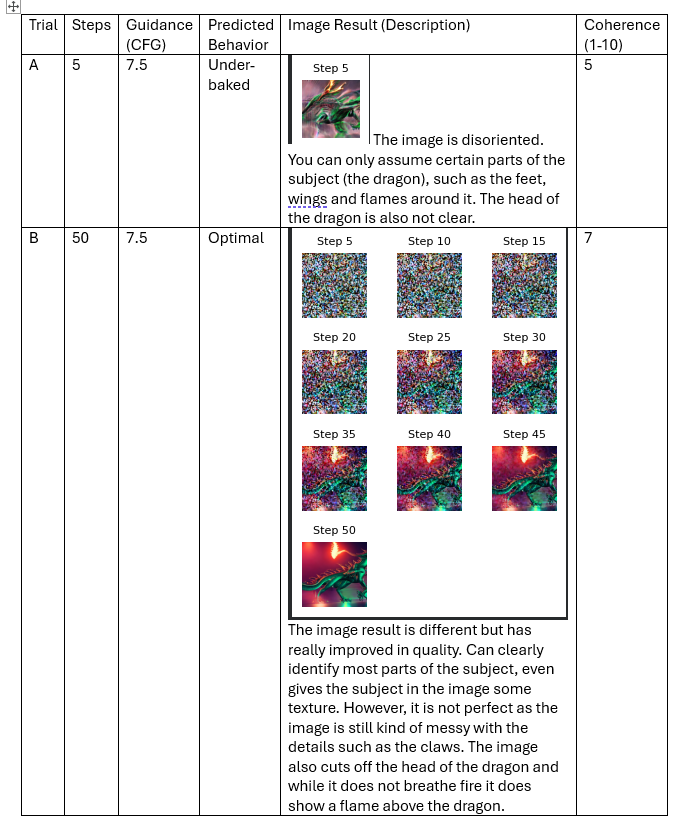

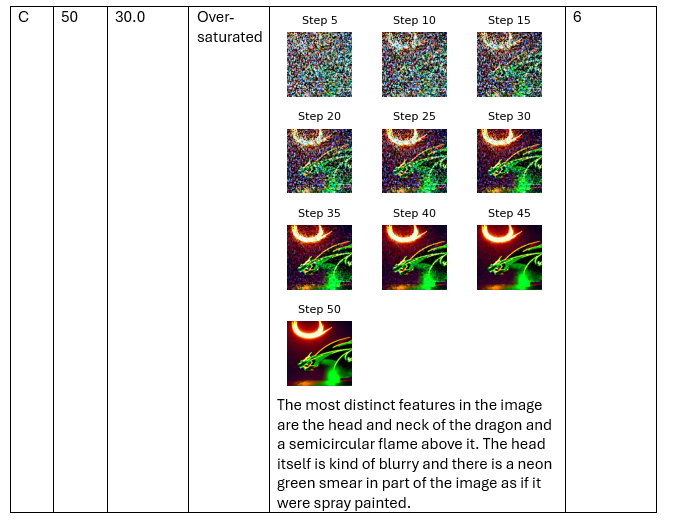

Compare Trial A to Trial B. Why does 5 steps result in a blurry ghost of an image?

Answer: The reason 5 steps result in a blurry ghost of an image is because at this stage there is still alot of noise to be removed from the image. You'll only see sharper details in later steps as more noise is removed, but in the earlier steps the details are still muddy.

In Trial C, look at the colors. Did they become more realistic, or did they start to become too bright/dark? Explain why.

Answer: Some colors in trail C became brighter, such as the green while the background became darker. It looked less realistic compared to trial B as the image in trial C showed less texture. This is due to using a high guidance scale, where the model prioritzes and follows every word in the prompt over providing a balance in maintaing high image quality and following the prompt.

Does doubling the steps double the time it takes to generate the image? Why or why not?

Answer: Yes. This is because the noise is subtracted iteratively from the image until the final image is generated so as the steps increase the computation time also increases. When experimenting I found that an image that was generated after 20 steps, may take 4 second, and if it was generated after 40 steps, it may take 8 seconds.

# Extra Credit

In [ ]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []
pipe.set_progress_bar_config(disable=True)

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="a mechanical dragon shooting green lines of code as fire,8k,raytracing",
    negative_prompt="green,text,mechanical",
    #negative_prompt="green,extra limbs, bad hands",
    generator=generator,
    num_inference_steps=50,
    guidance_scale=7.5,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
# intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

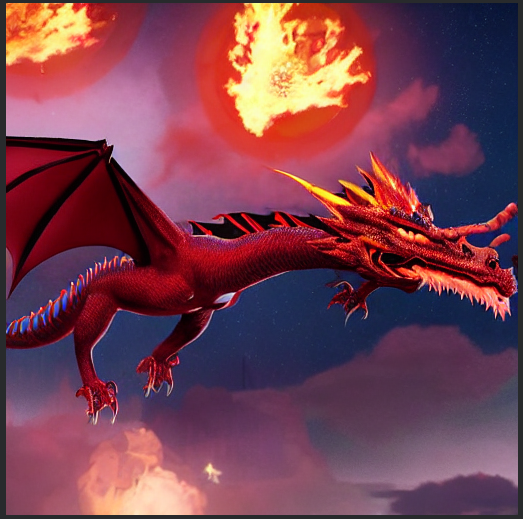

# Observed Results

The resulting image shows alot of fine details, especially the head of the dragon. This time the result is a red dragon flying in the sky, with clouds in the background as well as blue for the sky. It includes 2 fireballs which seem  more realistic compared to the flames in the previous trials. There are just a few funky errors such as a hand sticking out randomly and the back of the dragon.

# Negative Prompt vs Changing Positive Prompt

A positive prompt tells the model what you want and with changing the positive prompt the latent vectors can still move to certain concepts. With a negative prompt these concepts are completely avoided hence it is more powerful.  


Result based on how well it kept the result of prompt despite restrictions: 8